<a href="https://colab.research.google.com/github/HRNPH/GANime-FullBody/blob/main/ANIGans_FullBody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wgans

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
import os
import cv2

In [ ]:
#Util
from tqdm import tqdm

In [ ]:
#for consistency, all seeds are set to 0
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/Datasets/nparray_resized_ganime_fullbody_cleaned_ds/'
img_path = '/content/drive/MyDrive/Datasets/resized_ganime_fullbody_cleaned_ds/'
img_128_path = '/content/drive/MyDrive/Datasets/128x128_resized_ganime_fullbody_cleaned_ds/'
size = 256
batch_size = 20

## Data Example

In [ ]:
def pad_images_to_same_size(images,size):
  desired_size = size
  im = images

  old_size = im.shape[:2] # old_size is in (height, width) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  # new_size should be in (width, height) format

  im = cv2.resize(im, (new_size[1], new_size[0]))

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
  
  return new_im

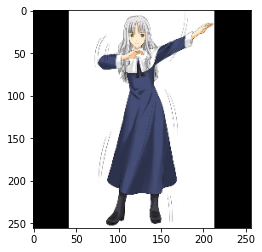

In [ ]:
image = cv2.imread(img_path + '/150.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = pad_images_to_same_size(image,size)

plt.imshow(image)

## LOAD DATA

In [ ]:
def load_img_data(path):
  #dat to save
  images = []

  counter = 0
  for each_file in tqdm(os.listdir(path)):
          
      #Get path name of image
      img_path = os.path.join(path, each_file)
      try:
          #Open image then resize
          image = cv2.imread(img_path) # Read as BGR
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          imaage = pad_images_to_same_size(image,128)
          # Append to images list
          images.append(image)

          counter += 1
      except:
          continue

  data = np.array(images, dtype = 'float32')

  del images

  print('---Finish---')
  return data

In [ ]:
#do every shit in one single line else my collab will blow up

train_loader = torch.utils.data.DataLoader(torch.tensor(np.moveaxis(np.load(data_path + 'data.npy')/255,-1,1)).float(), 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True,
                                           )

In [ ]:
train_loader = torch.utils.data.DataLoader(torch.tensor(np.moveaxis(load_img_data(img_128_path)/255,-1,1)).float(), 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True,
                                           )

100%|██████████| 10039/10039 [00:00<00:00, 297594.30it/s]

---Finish---


AxisError: ignored

In [ ]:
#Visualizer
def plotter(data):
  data = torch.moveaxis(data*255,1,-1).numpy().astype(int)
  fig,ax = plt.subplots(4,4,figsize=(5,5))
  for i in range(4):
    for j in range(4):
      ax[i,j].imshow(data[i+4*j])
      ax[i,j].axis('off')
  plt.show()

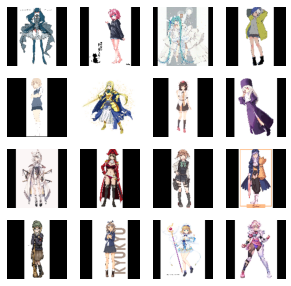

In [ ]:
for data in train_loader:
  plotter(data)
  break

In [ ]:
def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(200,200))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

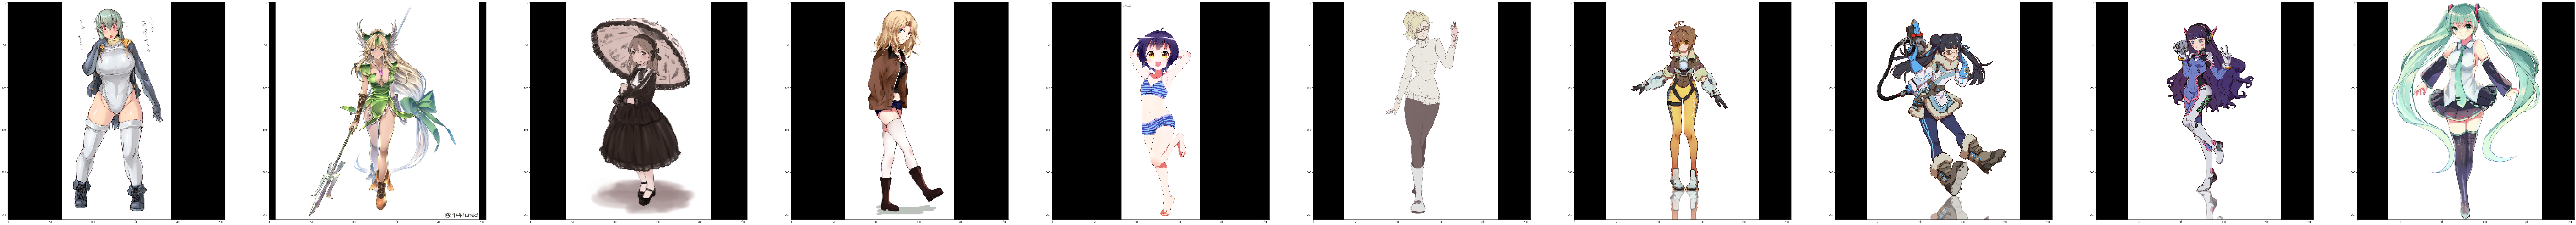

In [ ]:
show_images(data[0:10].astype(np.uint8))

## Construct model

## Base-Model

In [ ]:
class Wgenerator(nn.Module):

  def __init__(self, seed_size):

    super(Wgenerator, self).__init__()

    self.conv_transpose_block_1 = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 1024, 4, 1, 0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU()) #shape = (1024,4,4)
    
    self.conv_transpose_block_2 = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()) #shape = (512,8,8)
    
    self.conv_transpose_block_3 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()) #shape = (256,16,16)

    self.conv_transpose_block_4 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()) #shape = (128,32,32)

    self.conv_transpose_block_5 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()) #shape = (128,32,32)

    self.conv_transpose_block_6 = nn.Sequential(
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()) #shape = (3,64,64), outputs are normalized to (-1,1)

  def forward(self, input):
    input = self.conv_transpose_block_1(input)
    input = self.conv_transpose_block_2(input)
    input = self.conv_transpose_block_3(input)
    input = self.conv_transpose_block_4(input)
    input = self.conv_transpose_block_5(input)
    input = self.conv_transpose_block_6(input)
    return input

In [ ]:
class Wdiscriminator(nn.Module):

  def __init__(self, img_channel):

    super(Wdiscriminator, self).__init__()
    self.block = nn.Sequential(

        nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    )

  def forward(self,input):
    return self.block(input)

## Model Weight Init

In [ ]:
#weight
def weight_init(model):
  std = 0.02
  for layer in model.modules():
    name = layer.__class__.__name__
    if 'Conv' in name: #for all convolution and transpose convolution layers
      #init all weights to have a mean of 0 and std of 0.02
      mean = 0
      nn.init.normal_(layer.weight.data, mean, std)
    elif 'BatchNorm' in name: #for batchnorms, weight and bias refer to the gamma and beta values used in affine transformation
      mean = 1
      nn.init.normal_(layer.weight.data, mean, std)
      nn.init.constant_(layer.bias.data, 0)
    else:
      continue


In [ ]:
#Init the models
seed_size = 256
img_channel = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Wgenerator(seed_size)
weight_init(gen)

dis = Wdiscriminator(img_channel)
weight_init(dis)

gen.to(device)
dis.to(device)

print(device) #you should get cuda

cuda


In [ ]:
#optimizers 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#Gradient penalty, penaltizes normed gradients that is greater than one to prevent non-linear growth of critic/discriminator's score

def get_gradient(dis, real, fake, epsilon):
  mixed_images = real * epsilon + fake * (1 - epsilon)
  mixed_scores = dis(mixed_images)
  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores), 
      create_graph=True,
      retain_graph=True,
  )[0]
  return gradient

def gradient_penalty(gradient):

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm-1)**2)

  return penalty

#custom gen and dis loss, another minimax war rages on
def get_gen_loss(pred):
  return -torch.mean(pred)
  # gen loss is the -mean of the predicted value. this maximizes the pred value of the fake images

def get_dis_loss(fakepred, realpred, penalty, reg_lambda):
  return torch.mean(penalty*reg_lambda - realpred + fakepred)
  # dis loss is the mean of the difference between fake and real. this minimizes the error between the two. gradient penalty is added too

Iteration 0	[Epoch 0/20]	Losses:	 L_discriminator = 217.5700	 L_generator = -0.3817
Iteration 100	[Epoch 0/20]	Losses:	 L_discriminator = 245.6296	 L_generator = -0.7233
Iteration 200	[Epoch 0/20]	Losses:	 L_discriminator = 187.4524	 L_generator = -0.5771
Iteration 300	[Epoch 0/20]	Losses:	 L_discriminator = 261.4971	 L_generator = -0.3655
Iteration 400	[Epoch 0/20]	Losses:	 L_discriminator = 216.4783	 L_generator = -0.4045
Iteration 500	[Epoch 0/20]	Losses:	 L_discriminator = 370.8735	 L_generator = -0.3969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

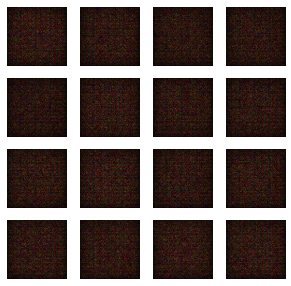

Iteration 0	[Epoch 1/20]	Losses:	 L_discriminator = 230.8754	 L_generator = 0.1566
Iteration 100	[Epoch 1/20]	Losses:	 L_discriminator = 204.9416	 L_generator = -0.5454
Iteration 200	[Epoch 1/20]	Losses:	 L_discriminator = 211.4294	 L_generator = -0.1902
Iteration 300	[Epoch 1/20]	Losses:	 L_discriminator = 187.6243	 L_generator = -0.2393
Iteration 400	[Epoch 1/20]	Losses:	 L_discriminator = 225.9398	 L_generator = -0.0103
Iteration 500	[Epoch 1/20]	Losses:	 L_discriminator = 265.0328	 L_generator = -0.4473
Iteration 0	[Epoch 2/20]	Losses:	 L_discriminator = 227.7350	 L_generator = 0.0757
Iteration 100	[Epoch 2/20]	Losses:	 L_discriminator = 254.3594	 L_generator = -0.2884
Iteration 200	[Epoch 2/20]	Losses:	 L_discriminator = 208.1406	 L_generator = -0.4257
Iteration 300	[Epoch 2/20]	Losses:	 L_discriminator = 331.1504	 L_generator = -0.4465
Iteration 400	[Epoch 2/20]	Losses:	 L_discriminator = 226.6452	 L_generator = -0.5534
Iteration 500	[Epoch 2/20]	Losses:	 L_discriminator = 284.27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

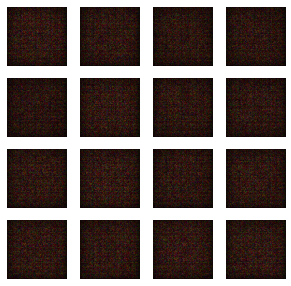

Iteration 0	[Epoch 3/20]	Losses:	 L_discriminator = 240.8728	 L_generator = -0.2594
Iteration 100	[Epoch 3/20]	Losses:	 L_discriminator = 224.2834	 L_generator = -0.3861
Iteration 200	[Epoch 3/20]	Losses:	 L_discriminator = 186.3421	 L_generator = -0.8955
Iteration 300	[Epoch 3/20]	Losses:	 L_discriminator = 220.4161	 L_generator = -0.8376
Iteration 400	[Epoch 3/20]	Losses:	 L_discriminator = 169.4257	 L_generator = -0.4721
Iteration 500	[Epoch 3/20]	Losses:	 L_discriminator = 253.7923	 L_generator = -0.5438
Iteration 0	[Epoch 4/20]	Losses:	 L_discriminator = 238.1709	 L_generator = -0.8046
Iteration 100	[Epoch 4/20]	Losses:	 L_discriminator = 243.3179	 L_generator = -0.3456
Iteration 200	[Epoch 4/20]	Losses:	 L_discriminator = 238.9342	 L_generator = -0.8945
Iteration 300	[Epoch 4/20]	Losses:	 L_discriminator = 267.8177	 L_generator = -0.2941
Iteration 400	[Epoch 4/20]	Losses:	 L_discriminator = 176.0763	 L_generator = -0.4522
Iteration 500	[Epoch 4/20]	Losses:	 L_discriminator = 247.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

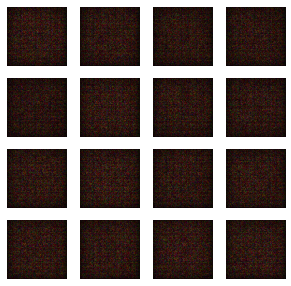

Iteration 0	[Epoch 5/20]	Losses:	 L_discriminator = 207.3456	 L_generator = -0.2226
Iteration 100	[Epoch 5/20]	Losses:	 L_discriminator = 215.9323	 L_generator = -0.5381
Iteration 200	[Epoch 5/20]	Losses:	 L_discriminator = 296.0022	 L_generator = -0.3345
Iteration 300	[Epoch 5/20]	Losses:	 L_discriminator = 274.8919	 L_generator = -0.3886
Iteration 400	[Epoch 5/20]	Losses:	 L_discriminator = 257.3844	 L_generator = -0.5792
Iteration 500	[Epoch 5/20]	Losses:	 L_discriminator = 219.6495	 L_generator = -0.5468
Iteration 0	[Epoch 6/20]	Losses:	 L_discriminator = 379.0464	 L_generator = -0.2496
Iteration 100	[Epoch 6/20]	Losses:	 L_discriminator = 212.6060	 L_generator = -0.6847
Iteration 200	[Epoch 6/20]	Losses:	 L_discriminator = 262.8968	 L_generator = -0.3403
Iteration 300	[Epoch 6/20]	Losses:	 L_discriminator = 273.1212	 L_generator = -0.7315
Iteration 400	[Epoch 6/20]	Losses:	 L_discriminator = 221.4585	 L_generator = -0.4697
Iteration 500	[Epoch 6/20]	Losses:	 L_discriminator = 290.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

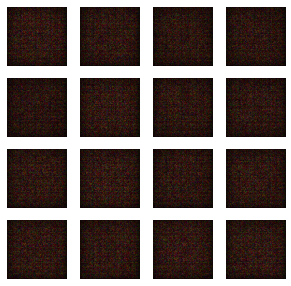

Iteration 0	[Epoch 7/20]	Losses:	 L_discriminator = 239.4122	 L_generator = -0.3834
Iteration 100	[Epoch 7/20]	Losses:	 L_discriminator = 244.4471	 L_generator = -0.5488
Iteration 200	[Epoch 7/20]	Losses:	 L_discriminator = 257.3877	 L_generator = -0.4899
Iteration 300	[Epoch 7/20]	Losses:	 L_discriminator = 283.6429	 L_generator = -0.5255
Iteration 400	[Epoch 7/20]	Losses:	 L_discriminator = 303.5788	 L_generator = 0.0282
Iteration 500	[Epoch 7/20]	Losses:	 L_discriminator = 242.7720	 L_generator = -0.8616
Iteration 0	[Epoch 8/20]	Losses:	 L_discriminator = 240.0869	 L_generator = -0.1206
Iteration 100	[Epoch 8/20]	Losses:	 L_discriminator = 225.4057	 L_generator = -0.3205
Iteration 200	[Epoch 8/20]	Losses:	 L_discriminator = 268.3744	 L_generator = -0.5635
Iteration 300	[Epoch 8/20]	Losses:	 L_discriminator = 258.6882	 L_generator = -0.4133
Iteration 400	[Epoch 8/20]	Losses:	 L_discriminator = 231.9982	 L_generator = -0.1302
Iteration 500	[Epoch 8/20]	Losses:	 L_discriminator = 230.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

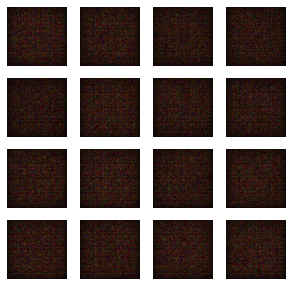

Iteration 0	[Epoch 9/20]	Losses:	 L_discriminator = 172.5135	 L_generator = -0.4529
Iteration 100	[Epoch 9/20]	Losses:	 L_discriminator = 288.5088	 L_generator = 0.1038
Iteration 200	[Epoch 9/20]	Losses:	 L_discriminator = 288.3289	 L_generator = -0.7208
Iteration 300	[Epoch 9/20]	Losses:	 L_discriminator = 228.6134	 L_generator = -0.1908
Iteration 400	[Epoch 9/20]	Losses:	 L_discriminator = 231.1213	 L_generator = -0.4962
Iteration 500	[Epoch 9/20]	Losses:	 L_discriminator = 245.8538	 L_generator = -0.6039
Iteration 0	[Epoch 10/20]	Losses:	 L_discriminator = 280.2240	 L_generator = -0.8156
Iteration 100	[Epoch 10/20]	Losses:	 L_discriminator = 223.8159	 L_generator = -0.5094
Iteration 200	[Epoch 10/20]	Losses:	 L_discriminator = 232.7986	 L_generator = -0.3183
Iteration 300	[Epoch 10/20]	Losses:	 L_discriminator = 228.0897	 L_generator = -0.0616
Iteration 400	[Epoch 10/20]	Losses:	 L_discriminator = 274.7034	 L_generator = -0.3233
Iteration 500	[Epoch 10/20]	Losses:	 L_discriminator =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

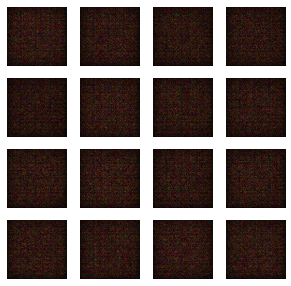

Iteration 0	[Epoch 11/20]	Losses:	 L_discriminator = 266.7898	 L_generator = -0.6523
Iteration 100	[Epoch 11/20]	Losses:	 L_discriminator = 209.5118	 L_generator = -0.0326
Iteration 200	[Epoch 11/20]	Losses:	 L_discriminator = 215.1692	 L_generator = -0.1337
Iteration 300	[Epoch 11/20]	Losses:	 L_discriminator = 234.7338	 L_generator = -0.2771
Iteration 400	[Epoch 11/20]	Losses:	 L_discriminator = 273.1902	 L_generator = -0.3712
Iteration 500	[Epoch 11/20]	Losses:	 L_discriminator = 180.2669	 L_generator = -0.5903
Iteration 0	[Epoch 12/20]	Losses:	 L_discriminator = 307.3634	 L_generator = -0.8913
Iteration 100	[Epoch 12/20]	Losses:	 L_discriminator = 294.9526	 L_generator = -0.3333
Iteration 200	[Epoch 12/20]	Losses:	 L_discriminator = 244.6535	 L_generator = -0.2038
Iteration 300	[Epoch 12/20]	Losses:	 L_discriminator = 228.5731	 L_generator = -0.5884
Iteration 400	[Epoch 12/20]	Losses:	 L_discriminator = 229.5834	 L_generator = -0.6072
Iteration 500	[Epoch 12/20]	Losses:	 L_discrimi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

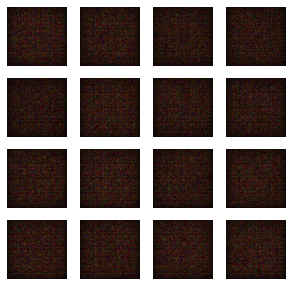

Iteration 0	[Epoch 13/20]	Losses:	 L_discriminator = 238.8730	 L_generator = -0.4601
Iteration 100	[Epoch 13/20]	Losses:	 L_discriminator = 186.6256	 L_generator = -0.7888
Iteration 200	[Epoch 13/20]	Losses:	 L_discriminator = 192.6790	 L_generator = -0.3758
Iteration 300	[Epoch 13/20]	Losses:	 L_discriminator = 175.4732	 L_generator = -0.6507
Iteration 400	[Epoch 13/20]	Losses:	 L_discriminator = 194.1929	 L_generator = -0.6201
Iteration 500	[Epoch 13/20]	Losses:	 L_discriminator = 245.6703	 L_generator = -0.2634
Iteration 0	[Epoch 14/20]	Losses:	 L_discriminator = 371.3743	 L_generator = -0.2818
Iteration 100	[Epoch 14/20]	Losses:	 L_discriminator = 202.9391	 L_generator = -0.2581
Iteration 200	[Epoch 14/20]	Losses:	 L_discriminator = 253.5242	 L_generator = -0.8138
Iteration 300	[Epoch 14/20]	Losses:	 L_discriminator = 273.5031	 L_generator = 0.0672
Iteration 400	[Epoch 14/20]	Losses:	 L_discriminator = 237.0541	 L_generator = -0.5920
Iteration 500	[Epoch 14/20]	Losses:	 L_discrimin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

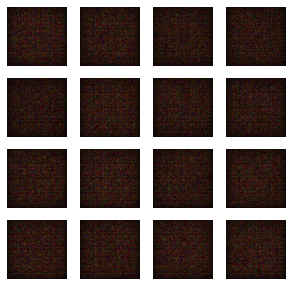

Iteration 0	[Epoch 15/20]	Losses:	 L_discriminator = 213.5518	 L_generator = -0.6311
Iteration 100	[Epoch 15/20]	Losses:	 L_discriminator = 285.8699	 L_generator = -0.5155
Iteration 200	[Epoch 15/20]	Losses:	 L_discriminator = 275.1627	 L_generator = 0.0937
Iteration 300	[Epoch 15/20]	Losses:	 L_discriminator = 303.0201	 L_generator = -0.2849
Iteration 400	[Epoch 15/20]	Losses:	 L_discriminator = 209.0532	 L_generator = -0.1771
Iteration 500	[Epoch 15/20]	Losses:	 L_discriminator = 224.3455	 L_generator = -0.3467
Iteration 0	[Epoch 16/20]	Losses:	 L_discriminator = 243.3334	 L_generator = -0.2697
Iteration 100	[Epoch 16/20]	Losses:	 L_discriminator = 276.2104	 L_generator = 0.0489
Iteration 200	[Epoch 16/20]	Losses:	 L_discriminator = 292.5533	 L_generator = -0.3233
Iteration 300	[Epoch 16/20]	Losses:	 L_discriminator = 224.5502	 L_generator = -0.5894
Iteration 400	[Epoch 16/20]	Losses:	 L_discriminator = 225.9879	 L_generator = -0.3803
Iteration 500	[Epoch 16/20]	Losses:	 L_discrimina

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

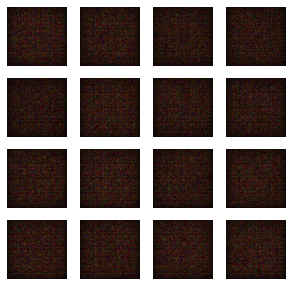

Iteration 0	[Epoch 17/20]	Losses:	 L_discriminator = 213.8567	 L_generator = -0.1637
Iteration 100	[Epoch 17/20]	Losses:	 L_discriminator = 291.0193	 L_generator = -0.4302
Iteration 200	[Epoch 17/20]	Losses:	 L_discriminator = 232.2726	 L_generator = 0.1185
Iteration 300	[Epoch 17/20]	Losses:	 L_discriminator = 366.7749	 L_generator = -0.5307
Iteration 400	[Epoch 17/20]	Losses:	 L_discriminator = 265.1527	 L_generator = -0.4436
Iteration 500	[Epoch 17/20]	Losses:	 L_discriminator = 262.3986	 L_generator = -0.4389
Iteration 0	[Epoch 18/20]	Losses:	 L_discriminator = 274.0202	 L_generator = -0.2533
Iteration 100	[Epoch 18/20]	Losses:	 L_discriminator = 214.7304	 L_generator = -0.4436
Iteration 200	[Epoch 18/20]	Losses:	 L_discriminator = 244.5641	 L_generator = 0.3025
Iteration 300	[Epoch 18/20]	Losses:	 L_discriminator = 228.3411	 L_generator = -0.0789
Iteration 400	[Epoch 18/20]	Losses:	 L_discriminator = 240.7314	 L_generator = -0.1252
Iteration 500	[Epoch 18/20]	Losses:	 L_discrimina

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

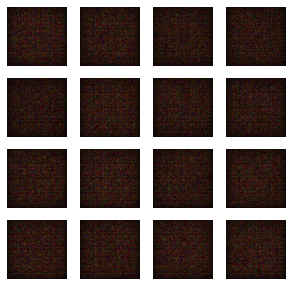

Iteration 0	[Epoch 19/20]	Losses:	 L_discriminator = 292.2706	 L_generator = -0.4888
Iteration 100	[Epoch 19/20]	Losses:	 L_discriminator = 209.0254	 L_generator = -0.3037
Iteration 200	[Epoch 19/20]	Losses:	 L_discriminator = 222.6883	 L_generator = -0.6315
Iteration 300	[Epoch 19/20]	Losses:	 L_discriminator = 215.0364	 L_generator = -0.5281
Iteration 400	[Epoch 19/20]	Losses:	 L_discriminator = 199.1358	 L_generator = -0.5323
Iteration 500	[Epoch 19/20]	Losses:	 L_discriminator = 272.0252	 L_generator = -0.4420


In [ ]:
num_epochs = 20
reg_lambda = 10
visualize_noise = torch.randn(batch_size, seed_size, 1, 1, device=device, dtype=torch.float) #don't touch this noise since we're using it for visualizations

for epoch in range(num_epochs):

  for i, data in enumerate(train_loader):

    b = data.shape[0]

    '''
    First step, we update the discriminator(critic)'s weights
    1. Have the generator generate fake images
    2. Input real images from trainloader
    3. Predict both fake and real images
    4. Compute gradient penalty with random epsilon for random abominations of real and fake images
    5. Compute the loss
    '''
    dis_optimizer.zero_grad()

    #step 1
    noise = torch.randn(b, seed_size, 1, 1, device=device, dtype=torch.float)
    fake_img = gen(noise)

    #step 2
    real_img = data.to(device)   

    #step 3
    fake_dis_pred = dis(fake_img.detach()) #we detach the fake images so that the generator isn't updated
    real_dis_pred = dis(real_img)

    #step 4
    epsilon = torch.rand(len(real_img), 1, 1, 1, device=device, requires_grad=True)
    gradient = get_gradient(dis, real_img, fake_img.detach(), epsilon)
    penalty = gradient_penalty(gradient)

    #step 5
    dis_loss = get_dis_loss(fake_dis_pred, real_dis_pred, penalty, reg_lambda)

    dis_loss.backward()
    dis_optimizer.step()

    '''
    Then, we update the generator's weights
    1. Have the generator generate fake images
    2. Have the trained discriminator predict the fake images
    3. Train the generator with the newly made generator loss function
    '''
    gen_optimizer.zero_grad()

    #step 1 is already done (using "fake_img")

    #step 2
    fake_gen_pred = dis(fake_img)

    #step 3
    gen_loss = get_gen_loss(fake_gen_pred.view(-1))
    gen_loss.backward()
    gen_optimizer.step()

    '''
    Lastly, we visualize
    '''

    dis_loss_show = '{:.4f}'.format(dis_loss.item())
    gen_loss_show = '{:.4f}'.format(gen_loss.item())

    if i%100==0:
      print(f'Iteration {i}\t[Epoch {epoch}/{num_epochs}]\tLosses:\t L_discriminator = {dis_loss_show}\t L_generator = {gen_loss_show}')
      #the only reason I output it this way is to make it look nice, nothing more. I'm an artistic individual

  with torch.no_grad():
    if epoch%2 == 0:
      pred = gen(visualize_noise)
      plotter(pred.cpu())
  torch.save(gen.state_dict(), '/content/drive/MyDrive/Datasets/save/128x128_resized_ganime_fullbody_cleaned_ds/w_gen.pt')
  torch.save(dis.state_dict(), '/content/drive/MyDrive/Datasets/save/128x128_resized_ganime_fullbody_cleaned_ds/w_dis.pt')

# Progans

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
#utils
import os
from tqdm import tqdm

#for consistency, all seeds are set to 69420
seed = 69420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Load data

In [ ]:
data_path = '/content/drive/MyDrive/Datasets/nparray_resized_ganime_fullbody_cleaned_ds/'
img_path = '/content/drive/MyDrive/Datasets/resized_ganime_fullbody_cleaned_ds/'
img_128_path = '/content/drive/MyDrive/Datasets/128x128_resized_ganime_fullbody_cleaned_ds/'
size = 256
batch_size = 16

In [ ]:
#do every shit in one single line else my collab will blow up
train_loader = torch.utils.data.DataLoader(torch.tensor(np.moveaxis(np.load(data_path + 'data.npy')/255,-1,1)).float(), 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True,
                                           )

## Construct Model

In [ ]:
#weight
def weight_init(model):
  std = 0.02
  for layer in model.modules():
    name = layer.__class__.__name__
    if 'Conv' in name: #for all convolution and transpose convolution layers
      #init all weights to have a mean of 0 and std of 0.02
      mean = 0
      nn.init.normal_(layer.weight.data, mean, std)
    elif 'BatchNorm' in name: #for batchnorms, weight and bias refer to the gamma and beta values used in affine transformation
      mean = 1
      nn.init.normal_(layer.weight.data, mean, std)
      nn.init.constant_(layer.bias.data, 0)
    else:
      continue

In [ ]:
Scaling = [1/4, 1/8, 1/16, 1/32]
#32 64 128 256

In [ ]:
class progenerator(nn.Module):

  def __init__(self, seed_size, in_channel):

    super(progenerator, self).__init__()
    
    self.init_transpose = nn.Sequential(
        nn.ConvTranspose2d(seed_size, in_channel, 4, 1, 0, bias=False),
        nn.BatchNorm2d(in_channel),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(in_channel, int(in_channel//2), 4, 2, 1, bias=False),
        nn.BatchNorm2d(int(in_channel//2)),
        nn.LeakyReLU(0.2)) 
    #shape = (in_channel,8,8)

    in_channel = int(in_channel//2)

    self.init_to_rgb = nn.Sequential(
        nn.Conv2d(in_channel, 3, 1, 1, 0, bias=False),
        nn.Tanh())
    
    self.progressive_blocks = nn.ModuleList() 
    self.to_rgb = nn.ModuleList() 
    self.to_rgb.append(self.init_to_rgb)

    for i in range(len(Scaling)-1):

      transpose = nn.Sequential(
        nn.ConvTranspose2d(int(in_channel*Scaling[i]), int(in_channel*Scaling[i+1]), 4, 2, 1, bias=False),
        nn.BatchNorm2d(int(in_channel*Scaling[i+1])),
        nn.LeakyReLU(0.2))
      self.progressive_blocks.append(transpose)

      to_rgb = nn.Sequential(
        nn.Conv2d(int(in_channel*Scaling[i+1]), 3, 1, 1, 0, bias=False),
        nn.Tanh())
      self.to_rgb.append(to_rgb)

  def forward(self,x,steps):
    
    x = self.init_transpose(x)

    for i in range(steps):
      x = self.progressive_blocks[i](x)

    return self.to_rgb[steps](x)

In [ ]:
class prodiscriminator(nn.Module):

  def __init__(self, in_channel):

    super(prodiscriminator, self).__init__()
    
    self.init_conv = nn.Sequential(
        nn.Conv2d(int(in_channel//2), in_channel, 4, 2, 1, bias=False),
        nn.BatchNorm2d(in_channel),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channel, 1, 4, 1, 0, bias=False),) 
    #reads (in_channel,8,8) into (1,1,1)

    in_channel = int(in_channel//2)
    self.init_from_rgb = nn.Sequential(
        nn.Conv2d(3, in_channel, 1, 1, 0, bias=False),
        nn.LeakyReLU(0.2))
    
    self.progressive_blocks = nn.ModuleList() 
    self.from_rgb = nn.ModuleList() 
    self.from_rgb.append(self.init_from_rgb)

    for i in range(len(Scaling)-1):

      conv = nn.Sequential(
        nn.Conv2d(int(in_channel*Scaling[i+1]), int(in_channel*Scaling[i]), 4, 2, 1, bias=False),
        nn.BatchNorm2d(int(in_channel*Scaling[i])),
        nn.LeakyReLU(0.2))
      self.progressive_blocks.append(conv)

      from_rgb = nn.Sequential(
        nn.Conv2d(3,int(in_channel*Scaling[i+1]), 1, 1, 0, bias=False),
        nn.LeakyReLU(0.2))
      self.from_rgb.append(from_rgb)

  def forward(self,x,steps):

    downscale_steps = int(np.log2(x.shape[2]/8)-steps)

    for _ in range(downscale_steps):
      x = nn.functional.interpolate(x, scale_factor=1/2, mode='nearest')

    x = self.from_rgb[steps](x)

    for i in range(steps):
      x = self.progressive_blocks[steps-i-1](x)

    x = self.init_conv(x)

    return x

In [ ]:
#Init the models
seed_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = progenerator(seed_size, 2048)
weight_init(gen)

dis = prodiscriminator(2048)
weight_init(dis)

gen.to(device)
dis.to(device)

print(device) #you should get cuda

cuda


In [ ]:
#optimizers 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#Gradient penalty, penaltizes normed gradients that is greater than one to prevent non-linear growth of critic/discriminator's score

def get_gradient(dis, real, fake, epsilon, step):

  downscale_steps = int(np.log2(real.shape[2]/fake.shape[2]))
  for _ in range(downscale_steps):
    real = nn.functional.interpolate(real, scale_factor=1/2, mode='nearest')

  mixed_images = real * epsilon + fake * (1 - epsilon)
  mixed_scores = dis(mixed_images, step)
  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores), 
      create_graph=True,
      retain_graph=True,
  )[0]
  return gradient

def gradient_penalty(gradient):

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm-1)**2)

  return penalty

#custom gen and dis loss, another minimax war rages on
def get_gen_loss(pred):
  return -torch.mean(pred)
  # gen loss is the -mean of the predicted value. this maximizes the pred value of the fake images

def get_dis_loss(fakepred, realpred, penalty, reg_lambda):
  return torch.mean(penalty*reg_lambda - realpred + fakepred)
  # dis loss is the mean of the difference between fake and real. this maximizes the error between the two. gradient penalty is added too

sumr = '''
Summary
1. The generator tries to maximize the predicted value on fake images.
2. The discriminator tries to maximize the predicted value on real images, meanwhile keeping fake images far away.
3. As such, the discriminator proves no use rather than to train the generator, which is why it's called the critic.
4. Gradients are encouraged to stay around 1 to avoid rapid movement of the predicted value (which may break the GAN).
'''

print(sumr)


Summary
1. The generator tries to maximize the predicted value on fake images.
2. The discriminator tries to maximize the predicted value on real images, meanwhile keeping fake images far away.
3. As such, the discriminator proves no use rather than to train the generator, which is why it's called the critic.
4. Gradients are encouraged to stay around 1 to avoid rapid movement of the predicted value (which may break the GAN).



## Trainning

In [ ]:
#Visualizer
def plotter(data):
  data = torch.moveaxis(data*255,1,-1).numpy().astype(int)
  fig,ax = plt.subplots(4,4,figsize=(5,5))
  for i in range(4):
    for j in range(4):
      ax[i,j].imshow(data[i+4*j])
      ax[i,j].axis('off')
  plt.show()

### Load trained model to countinue

In [ ]:
gen.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/save/256x256_progans_fullbody/progressivegen.pt'))
dis.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/save/256x256_progans_fullbody/progressivedis.pt'))

<All keys matched successfully>

In [ ]:
num_epochs = [0,60,80,100]
reg_lambda = 10
steps = [i for i in range(len(num_epochs))]

In [ ]:
for step in steps:
  print(step)
  print(seed_size * Scaling[step])
  pass

0
256.0
1
128.0
2
64.0
3
32.0


In [ ]:
visualize_noise = torch.randn(batch_size, seed_size, 1, 1, device=device, dtype=torch.float) #don't touch this noise since we're using it for visualizations

for step in steps:

  for epoch in range(num_epochs[step]):

    for i, data in enumerate(train_loader):

      gen.train()
      dis.train()

      b = data.shape[0]

      '''
      First step, we update the discriminator(critic)'s weights
      1. Have the generator generate fake images
      2. Input real images from trainloader
      3. Predict both fake and real images
      4. Compute gradient penalty with random epsilon for random abominations of real and fake images
      5. Compute the loss
      '''
      dis_optimizer.zero_grad()

      #step 1
      noise = torch.randn(b, seed_size, 1, 1, device=device, dtype=torch.float)
      print(step)
      fake_img = gen(noise, step)

      #step 2
      real_img = data.to(device)   

      #step 3
      fake_dis_pred = dis(fake_img.detach(), step) #we detach the fake images so that the generator isn't updated
      real_dis_pred = dis(real_img, step)

      #step 4
      epsilon = torch.rand(len(real_img), 1, 1, 1, device=device, requires_grad=True)
      gradient = get_gradient(dis, real_img, fake_img.detach(), epsilon, step)
      penalty = gradient_penalty(gradient)

      #step 5
      dis_loss = get_dis_loss(fake_dis_pred, real_dis_pred, penalty, reg_lambda)

      dis_loss.backward()
      dis_optimizer.step()

      '''
      Then, we update the generator's weights
      1. Have the generator generate fake images
      2. Have the trained discriminator predict the fake images
      3. Train the generator with the newly made generator loss function
      '''
      gen_optimizer.zero_grad()

      #step 1 is already done (using "fake_img")

      #step 2
      fake_gen_pred = dis(fake_img, step)

      #step 3
      gen_loss = get_gen_loss(fake_gen_pred.view(-1))
      gen_loss.backward()
      gen_optimizer.step()

      '''
      Lastly, we visualize
      '''

      dis_loss_show = '{:.4f}'.format(dis_loss.item())
      gen_loss_show = '{:.4f}'.format(gen_loss.item())

      if i%100==0:
        print(f'Iteration {i}\t[Epoch {epoch}/{num_epochs[step]}]\tLosses:\t L_discriminator = {dis_loss_show}\t L_generator = {gen_loss_show}')
        #the only reason I output it this way is to make it look nice, nothing more. I'm an artistic individual

    with torch.no_grad():
      if epoch%3 == 0:
        gen.eval()
        pred = gen(visualize_noise, step)
        plotter(pred.cpu())

    #save model weights for generator and discriminator

    torch.save(gen.state_dict(), '/content/drive/MyDrive/ganime/progressivegen.pt')
    torch.save(dis.state_dict(), '/content/drive/MyDrive/ganime/progressivedis.pt')

1


RuntimeError: ignored

## Show Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

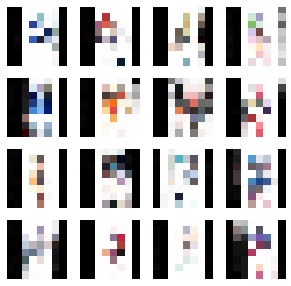

In [ ]:
visualize_noise = torch.randn(batch_size, seed_size, 1, 1, device=device, dtype=torch.float) #don't touch this noise since we're using it for visualizations
num_epochs = [0,60,80,100]
steps = [i for i in range(4)]
pred = gen(visualize_noise, steps[0])
plotter(pred.cpu().detach())